## 모델링

In [1]:
#한글 깨짐 -> 설치 후 런타임 다시 시작 필요!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (31.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [2]:
# MeCab, nltk 설치
!pip install nltk
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-09-01 13:47:04--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-01 13:47:04--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaef5b7c42be0756066c3228175.dl.dropboxusercontent.com/cd/0/get/BsELy11dNWu4nj4ihADz1QtwqiTtD6Zi0yH0qyhzHE0S63wJYZEvX-XjS5afTIGnnOfwzWUyBXucHyd7S0HTdlJavl6EdWuSRyxG04CCOjXRAsJ47GGmkne-zMgZIfoOBQDl_UOXXwiyv3CtOPf7PMXuUq429Szyj3ZhRqnoAhBLnWeaCElL8825N7KfpsrvdzU/file?dl=1# [following]
--2022-09-

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import random as rn
import re
import os
import warnings
import folium
import geopy.distance
import konlpy
import MeCab
from collections import Counter
from konlpy.tag import Kkma, Komoran, Hannanum, Okt, Mecab
from konlpy.utils import pprint
from nltk import Text
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.layers import Dense, Activation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


plt.rc('font',  family='NanumBarunGothic')
plt.rcParams["axes.unicode_minus"]=False #마이너스 깨짐 해결
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (1) 데이터 불러오기

#### 1) train,test data

In [53]:
data="/content/drive/MyDrive/Project/팀 프로젝트/3_company_dinner/data/"

In [54]:
df = pd.read_csv(os.path.join(data,"company_dinner_tokenization2019.csv"),index_col=0)
df=df.reset_index(drop=True)
df['review']=df['review'].fillna("")
df['review_check']=df['review_check'].fillna("")
df.head()

,store_name,date,review,length,review_check,check_length,menu,mood,service,price,...,삼거리,맛,맛집,메뉴_음식,친절_직원,때,예약,가격,분위기,추천
0,백억하누 강남본점,2020-01-03,네이버로 예약하고 방문했는데 사정이 있어 조용한 구석자리를 부탁한다고 썼는데도 구석...,358,네이버로 예약하고 방문했는데 사정이 있어 조용한 구석 자리를 부탁한다고 썼는데도 구...,370,1,1,1,1,...,0,0,0,1,1,0,1,0,0,0
1,강남진해장,2022-04-05,일반적인 양평해장국과 다르게 기본 간이 되어있고 베이스가 육개장과 뼈해장국같은 느...,343,일반적인 양평 해장국과 다르게 기본 간이 되어 있고 베이스가 육개장과 뼈해장국 같은...,348,1,1,1,1,...,0,1,0,1,0,0,0,1,0,0
2,백억하누 강남본점,2022-05-07,개인룸이 있고 룸안에 화장실이 있어 너무 편하고 좋았는데 옆에 개인 서랍이 있는지...,163,개인 룸이 있고 룸 안에 화장실이 있어 너무 편하고 좋았는데 옆에 개인 서랍이 있는...,165,1,1,1,0,...,0,1,0,1,1,0,0,0,0,0
3,딘타이펑 강남점,2019-11-21,분위기도 괜찮고 맛있어요 네이버예약 덕분에 에이드도 서비스로 나왔네요 가격은 비싸지...,59,분위기도 괜찮고 맛있어요 네이버예약 덕분에 에이드도 서비스로 나왔네요 가격은 비싸지...,59,1,1,1,1,...,0,1,0,0,0,0,1,1,1,0
4,백억하누 강남본점,2021-05-25,룸으로 이용했는데 화장실도 딸려있어서 너무 편했어요 삼합 재료들이 신선해서 생각보다...,265,룸으로 이용했는데 화장실도 딸려 있어서 너무 편했어요 삼합 재료들이 신선해서 생각보...,276,1,1,0,1,...,0,1,0,1,0,0,0,0,0,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   store_name    7822 non-null   object
 1   date          7822 non-null   object
 2   review        7822 non-null   object
 3   length        7822 non-null   int64 
 4   review_check  7822 non-null   object
 5   check_length  7822 non-null   int64 
 6   menu          7822 non-null   int64 
 7   mood          7822 non-null   int64 
 8   service       7822 non-null   int64 
 9   price         7822 non-null   int64 
 10  clean         7822 non-null   int64 
 11  room          7822 non-null   int64 
 12  parking       7822 non-null   int64 
 13  photo         7822 non-null   int64 
 14  sum           7822 non-null   int64 
 15  helpful       7822 non-null   int64 
 16  store         7822 non-null   int64 
 17  딘타이펑          7822 non-null   int64 
 18  백억하누          7822 non-null   int64 
 19  느린마을  

In [56]:
df.columns

Index(['store_name', 'date', 'review', 'length', 'review_check',
       'check_length', 'menu', 'mood', 'service', 'price', 'clean', 'room',
       'parking', 'photo', 'sum', 'helpful', 'store', '딘타이펑', '백억하누', '느린마을',
       '화기애애', '라그릴리아', '강남진해장', '구스', '파파야리프', '고양이부엌', '시골야채된장', '을밀대', '담소',
       '청류벽', '기리야마', '시카고', '대려도', '신부자', '봉추찜닭', '리샨', '봉피양', 'Pavox', '삼거리',
       '맛', '맛집', '메뉴_음식', '친절_직원', '때', '예약', '가격', '분위기', '추천'],
      dtype='object')

In [57]:
df['store_name'].unique(), len(df['store_name'].unique())

(array(['백억하누 강남본점', '강남진해장', '딘타이펑 강남점', '삼거리포차', '화기애애 강남역점',
        '느린마을양조장 강남점', '시골야채된장', '봉피양제주 강남점', '라그릴리아 SPC스퀘어점', '청류벽',
        '대려도', '신부자식당', '리샨 삼성타운점', '구스아일랜드 브루하우스', '을밀대 강남점', '파파야리프',
        '고양이부엌', '오리지널시카고피자', 'Pavox', '우동명가기리야마본진', '담소사골순대 강남본점',
        '봉추찜닭 강남주공공이점'], dtype=object), 22)

#### 2) real data 

In [184]:
new = pd.read_csv(os.path.join(data,"company_dinner_add_review.csv"))
new.head()

,store_name,date,review,review_check,check_length,helpful,맛,맛집,메뉴_음식,친절_직원,때,예약,가격,분위기,추천
0,맛보리생돼지김치두루치기,2021.09.13,맛있어요.\n3명기준 2인분+계란말이 추천,맛있어요 3명 기준 2인분 계란말이 추천,22,0,1,0,0,0,0,0,0,0,1
1,맛보리생돼지김치두루치기,2021.09.13,계란말이 추천합니다,계란말이 추천합니다,10,0,0,0,0,0,0,0,0,0,1
2,와인코르크 강남점,2022.04.23,이와인 추천으로 먹었는데 저어어엉말 맛있었어요!!^^여러가지 안주먹었는데 치즈플레이...,이 와인 추천으로 먹었는데 정말 맛있었어요 웃음 여러 가지 안주 먹었는데 치즈플레이...,310,1,1,1,1,1,0,0,1,1,1
3,맛보리생돼지김치두루치기,2022.08.26,맛있어요,맛있어요,4,0,1,0,0,0,0,0,0,0,0
4,맛보리생돼지김치두루치기,2022.08.22,맛있습니다,맛있습니다,5,0,1,0,0,0,0,0,0,0,0


In [185]:
new['딘타이펑']=0
new['백억하누']=0
new['느린마을']=0
new['화기애애']=0
new['라그릴리아']=0
new['강남진해장']=0
new['구스']=0
new['파파야리프']=0
new['고양이부엌']=0
new['시골야채된장']=0
new['을밀대']=0
new['담소']=0
new['청류벽']=0
new['기리야마']=0
new['시카고']=0
new['대려도']=0
new['신부자']=0
new['봉추찜닭']=0
new['리샨']=0
new['봉피양']=0
new['Pavox']=0
new['삼거리']=0
new.head()

,store_name,date,review,review_check,check_length,helpful,맛,맛집,메뉴_음식,친절_직원,...,청류벽,기리야마,시카고,대려도,신부자,봉추찜닭,리샨,봉피양,Pavox,삼거리
0,맛보리생돼지김치두루치기,2021.09.13,맛있어요.\n3명기준 2인분+계란말이 추천,맛있어요 3명 기준 2인분 계란말이 추천,22,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,맛보리생돼지김치두루치기,2021.09.13,계란말이 추천합니다,계란말이 추천합니다,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,와인코르크 강남점,2022.04.23,이와인 추천으로 먹었는데 저어어엉말 맛있었어요!!^^여러가지 안주먹었는데 치즈플레이...,이 와인 추천으로 먹었는데 정말 맛있었어요 웃음 여러 가지 안주 먹었는데 치즈플레이...,310,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,맛보리생돼지김치두루치기,2022.08.26,맛있어요,맛있어요,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,맛보리생돼지김치두루치기,2022.08.22,맛있습니다,맛있습니다,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
# 의미없는 기호 제거
def cleanText(readData):
    text = re.sub('[-=+,#/\?:;^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…]', '', readData)
    return text

# 의미없는 자음,모음 제거
def cleanText2(readData):
    text = re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅃㅉㄸㄲㅆㅛㅕㅑㅐㅔㅗㅓㅏㅣㅜㅠㅡ]', '', readData)
    return text

In [187]:
#'\n', '\r' -> ' '로 변환, 의미없는 기호, 자음모음 제거
df['review_check'] = df['review_check'].apply(lambda x: x.replace('\n',' '))
df['review_check'] = df['review_check'].apply(lambda x: x.replace('\r',' '))
df['review_check'] = df['review_check'].apply(cleanText)
df['review_check'] = df['review_check'].apply(cleanText2)
df['check_length'] = df['review_check'].apply(lambda x: len(x))

In [188]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   store_name    158 non-null    object
 1   date          158 non-null    object
 2   review        158 non-null    object
 3   review_check  158 non-null    object
 4   check_length  158 non-null    int64 
 5   helpful       158 non-null    int64 
 6   맛             158 non-null    int64 
 7   맛집            158 non-null    int64 
 8   메뉴_음식         158 non-null    int64 
 9   친절_직원         158 non-null    int64 
 10  때             158 non-null    int64 
 11  예약            158 non-null    int64 
 12  가격            158 non-null    int64 
 13  분위기           158 non-null    int64 
 14  추천            158 non-null    int64 
 15  딘타이펑          158 non-null    int64 
 16  백억하누          158 non-null    int64 
 17  느린마을          158 non-null    int64 
 18  화기애애          158 non-null    int64 
 19  라그릴리아   

In [63]:
new=new[['date', 'review_check', 'check_length','helpful', '딘타이펑', '백억하누', '느린마을',
       '화기애애', '라그릴리아', '강남진해장', '구스', '파파야리프', '고양이부엌', '시골야채된장', '을밀대', '담소',
       '청류벽', '기리야마', '시카고', '대려도', '신부자', '봉추찜닭', '리샨', '봉피양', 'Pavox', '삼거리',
       '맛', '맛집', '메뉴_음식', '친절_직원', '때', '예약', '가격', '분위기', '추천']]
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          158 non-null    object
 1   review_check  158 non-null    object
 2   check_length  158 non-null    int64 
 3   helpful       158 non-null    int64 
 4   딘타이펑          158 non-null    int64 
 5   백억하누          158 non-null    int64 
 6   느린마을          158 non-null    int64 
 7   화기애애          158 non-null    int64 
 8   라그릴리아         158 non-null    int64 
 9   강남진해장         158 non-null    int64 
 10  구스            158 non-null    int64 
 11  파파야리프         158 non-null    int64 
 12  고양이부엌         158 non-null    int64 
 13  시골야채된장        158 non-null    int64 
 14  을밀대           158 non-null    int64 
 15  담소            158 non-null    int64 
 16  청류벽           158 non-null    int64 
 17  기리야마          158 non-null    int64 
 18  시카고           158 non-null    int64 
 19  대려도     

In [64]:
df=df[['date', 'review_check', 'check_length','helpful', '딘타이펑', '백억하누', '느린마을',
       '화기애애', '라그릴리아', '강남진해장', '구스', '파파야리프', '고양이부엌', '시골야채된장', '을밀대', '담소',
       '청류벽', '기리야마', '시카고', '대려도', '신부자', '봉추찜닭', '리샨', '봉피양', 'Pavox', '삼거리',
       '맛', '맛집', '메뉴_음식', '친절_직원', '때', '예약', '가격', '분위기', '추천']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7822 non-null   object
 1   review_check  7822 non-null   object
 2   check_length  7822 non-null   int64 
 3   helpful       7822 non-null   int64 
 4   딘타이펑          7822 non-null   int64 
 5   백억하누          7822 non-null   int64 
 6   느린마을          7822 non-null   int64 
 7   화기애애          7822 non-null   int64 
 8   라그릴리아         7822 non-null   int64 
 9   강남진해장         7822 non-null   int64 
 10  구스            7822 non-null   int64 
 11  파파야리프         7822 non-null   int64 
 12  고양이부엌         7822 non-null   int64 
 13  시골야채된장        7822 non-null   int64 
 14  을밀대           7822 non-null   int64 
 15  담소            7822 non-null   int64 
 16  청류벽           7822 non-null   int64 
 17  기리야마          7822 non-null   int64 
 18  시카고           7822 non-null   int64 
 19  대려도   

In [74]:
df_new = pd.concat([df,new])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 0 to 157
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          7980 non-null   object
 1   review_check  7980 non-null   object
 2   check_length  7980 non-null   int64 
 3   helpful       7980 non-null   int64 
 4   딘타이펑          7980 non-null   int64 
 5   백억하누          7980 non-null   int64 
 6   느린마을          7980 non-null   int64 
 7   화기애애          7980 non-null   int64 
 8   라그릴리아         7980 non-null   int64 
 9   강남진해장         7980 non-null   int64 
 10  구스            7980 non-null   int64 
 11  파파야리프         7980 non-null   int64 
 12  고양이부엌         7980 non-null   int64 
 13  시골야채된장        7980 non-null   int64 
 14  을밀대           7980 non-null   int64 
 15  담소            7980 non-null   int64 
 16  청류벽           7980 non-null   int64 
 17  기리야마          7980 non-null   int64 
 18  시카고           7980 non-null   int64 
 19  대려도    

In [75]:
df_new.tail()

,date,review_check,check_length,helpful,딘타이펑,백억하누,느린마을,화기애애,라그릴리아,강남진해장,...,삼거리,맛,맛집,메뉴_음식,친절_직원,때,예약,가격,분위기,추천
153,2020.08.14,가격도 저렴하고 좋아요 웃음 재방문 의사 있습니다,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
154,2020.07.29,강남역 분위기도 좋고 저렴한 와인 맛집 와인 종류도 많고 원하는 와인 골라서 가져다...,80,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
155,2020.05.04,샹그리아 맛집 웃음,10,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
156,2020.05.01,강남에서 제일 좋은 와인 집,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,2019.12.31,와인 가볍게 즐기기 좋은 곳,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### (2) 토큰화 함수 만들기

#### getNVM_lemma2_stopword
- 하기 태그만 사용 + 불용어 제거
- 'NNG','NNP', 'SN', 'NR', 'VA', 'VV', 'VCN', 'VCP', 'XPN', 'XR', 'XSN', 'NNBC'만 이용

In [66]:
stop_words = ['한우','하','포장','평양냉면','탕','타이','전복','전','재','우동','오','안주','소고기','세트','샤오','새우','삼합','사람','볶음밥','보','바오','면','맥주','말','막국수','막걸리','룽','떡볶이','딤섬','딘','들기름','들','되','느끼','네이버','냉면','나오','김치','굽','국물','고기','강남','가']
len(stop_words)
def getNVM_lemma2(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    #print(parsed)
    word_tag = [w for w in parsed.split("\n")] 
    pos = []
    tags = ['NNG','NNP', 'SN', 'NR', 'VA', 'VV', 'VCN', 'VCP', 'XPN', 'XR', 'NNBC']
   
    for word_ in word_tag[:-2]:
        word = word_.split('\t') #['아버지', 'NNG,*,F,아버지,*,*,*,*']
        tag = word[1].split(",")  #['EC', '*', 'F', '는다', '*', '*', '*', '*']
        if('+' in tag[0]): #단어가 여러 형태소로 구성된 경우
            if ('VV' in tag[0] or 'VA' in tag[0]):
                t = tag[-1].split('/')[0]
                if t not in stop_words:
                    pos.append(t)
        if ((tag[0] in tags) and (word[0] not in stop_words)):
          pos.append(word[0])
    return pos

### (3) Logistic Regression

#### 1) tfidf, count Vector

In [159]:
#모델용
tfidf = TfidfVectorizer(ngram_range=(1,2),tokenizer = getNVM_lemma2, preprocessor = None, lowercase = False)
cv = CountVectorizer(ngram_range=(1,2),tokenizer = getNVM_lemma2, preprocessor = None, lowercase = False)
tdm_tfidf = tfidf.fit_transform(df['review_check'].values.astype('U'))
tdm_cv= cv.fit_transform(df['review_check'].values.astype('U'))

In [154]:
tdm_cv_dn= cv.fit_transform(df_new['review_check'].values.astype('U'))

#### 2) x (feature)

In [20]:
# x_cv_1 : 리뷰, 리뷰길이, 가게명, 키워드 전체
x_cv_1 = tdm_cv.toarray() # TDM (countvector) 추가
x_cv_len_1 = []
for i in range(len(x_cv_1)):
    a = x_cv_1[i]
    a = np.append(a,np.log(df['check_length'][i]+1)) # 길이 컬럼 추가
 
    a = np.append(a, df['딘타이펑'][i])    
    a = np.append(a, df['백억하누'][i])
    a = np.append(a, df['느린마을'][i])   
    a = np.append(a, df['화기애애'][i])    
    a = np.append(a, df['라그릴리아'][i])    
    a = np.append(a, df['강남진해장'][i])    
    a = np.append(a, df['구스'][i])
    a = np.append(a, df['파파야리프'][i])   
    a = np.append(a, df['고양이부엌'][i])    
    a = np.append(a, df['시골야채된장'][i])    
    a = np.append(a, df['을밀대'][i])    
    a = np.append(a, df['담소'][i])
    a = np.append(a, df['청류벽'][i])    
    a = np.append(a, df['기리야마'][i])
    a = np.append(a, df['신부자'][i])    
    a = np.append(a, df['시카고'][i])    
    a = np.append(a, df['대려도'][i])    
    a = np.append(a, df['봉추찜닭'][i])    
    a = np.append(a, df['리샨'][i])
    a = np.append(a, df['봉피양'][i])       
    a = np.append(a, df['Pavox'][i])    
    a = np.append(a, df['삼거리'][i])  
 
    a = np.append(a, df['맛'][i])
    a = np.append(a, df['맛집'][i])
    a = np.append(a, df['메뉴_음식'][i])
    a = np.append(a, df['친절_직원'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['분위기'][i])
    a = np.append(a, df['추천'][i])  

    x_cv_len_1.append(a)

In [ ]:
# x_cv_2 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 서비스(친절_직원) 제외)
x_cv_2 = tdm_cv.toarray() # TDM (countvector) 추가
x_cv_len_2 = []
for i in range(len(x_cv_2)):
    a = x_cv_2[i]
    a = np.append(a,np.log(df['check_length'][i]+1)) # 길이 컬럼 추가
 
    a = np.append(a, df['딘타이펑'][i])    
    a = np.append(a, df['백억하누'][i])
    a = np.append(a, df['느린마을'][i])   
    a = np.append(a, df['화기애애'][i])    
    a = np.append(a, df['라그릴리아'][i])    
    a = np.append(a, df['강남진해장'][i])    
    a = np.append(a, df['구스'][i])
    a = np.append(a, df['파파야리프'][i])   
    a = np.append(a, df['고양이부엌'][i])    
    a = np.append(a, df['시골야채된장'][i])    
    a = np.append(a, df['을밀대'][i])    
    a = np.append(a, df['담소'][i])
    a = np.append(a, df['청류벽'][i])    
    a = np.append(a, df['기리야마'][i])
    a = np.append(a, df['신부자'][i])    
    a = np.append(a, df['시카고'][i])    
    a = np.append(a, df['대려도'][i])    
    a = np.append(a, df['봉추찜닭'][i])    
    a = np.append(a, df['리샨'][i])
    a = np.append(a, df['봉피양'][i])       
    a = np.append(a, df['Pavox'][i])    
    a = np.append(a, df['삼거리'][i])  
 
    a = np.append(a, df['맛집'][i])
    a = np.append(a, df['메뉴_음식'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['분위기'][i])
    a = np.append(a, df['추천'][i])  

    x_cv_len_2.append(a)

In [ ]:
# x_cv_3 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 맛집, 메뉴_음식 제외)
x_cv_3 = tdm_cv.toarray() # TDM (countvector) 추가
x_cv_len_3 = []
for i in range(len(x_cv_3)):
    a = x_cv_3[i]
    a = np.append(a,np.log(df['check_length'][i]+1)) # 길이 컬럼 추가
 
    a = np.append(a, df['딘타이펑'][i])    
    a = np.append(a, df['백억하누'][i])
    a = np.append(a, df['느린마을'][i])   
    a = np.append(a, df['화기애애'][i])    
    a = np.append(a, df['라그릴리아'][i])    
    a = np.append(a, df['강남진해장'][i])    
    a = np.append(a, df['구스'][i])
    a = np.append(a, df['파파야리프'][i])   
    a = np.append(a, df['고양이부엌'][i])    
    a = np.append(a, df['시골야채된장'][i])    
    a = np.append(a, df['을밀대'][i])    
    a = np.append(a, df['담소'][i])
    a = np.append(a, df['청류벽'][i])    
    a = np.append(a, df['기리야마'][i])
    a = np.append(a, df['신부자'][i])    
    a = np.append(a, df['시카고'][i])    
    a = np.append(a, df['대려도'][i])    
    a = np.append(a, df['봉추찜닭'][i])    
    a = np.append(a, df['리샨'][i])
    a = np.append(a, df['봉피양'][i])       
    a = np.append(a, df['Pavox'][i])    
    a = np.append(a, df['삼거리'][i])  
 
    a = np.append(a, df['친절_직원'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['분위기'][i])
    a = np.append(a, df['추천'][i]) 

    x_cv_len_3.append(a)

In [ ]:
# x_cv_4 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 맛집, 분위기 제외)
x_cv_4 = tdm_cv.toarray() # TDM (countvector) 추가
x_cv_len_4 = []
for i in range(len(x_cv_4)):
    a = x_cv_4[i]
    a = np.append(a,np.log(df['check_length'][i]+1)) # 길이 컬럼 추가
 
    a = np.append(a, df['딘타이펑'][i])    
    a = np.append(a, df['백억하누'][i])
    a = np.append(a, df['느린마을'][i])   
    a = np.append(a, df['화기애애'][i])    
    a = np.append(a, df['라그릴리아'][i])    
    a = np.append(a, df['강남진해장'][i])    
    a = np.append(a, df['구스'][i])
    a = np.append(a, df['파파야리프'][i])   
    a = np.append(a, df['고양이부엌'][i])    
    a = np.append(a, df['시골야채된장'][i])    
    a = np.append(a, df['을밀대'][i])    
    a = np.append(a, df['담소'][i])
    a = np.append(a, df['청류벽'][i])    
    a = np.append(a, df['기리야마'][i])
    a = np.append(a, df['신부자'][i])    
    a = np.append(a, df['시카고'][i])    
    a = np.append(a, df['대려도'][i])    
    a = np.append(a, df['봉추찜닭'][i])    
    a = np.append(a, df['리샨'][i])
    a = np.append(a, df['봉피양'][i])       
    a = np.append(a, df['Pavox'][i])    
    a = np.append(a, df['삼거리'][i])  
 
    a = np.append(a, df['메뉴_음식'][i])
    a = np.append(a, df['친절_직원'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['추천'][i])  

    x_cv_len_4.append(a)

In [80]:
# x_cv_5 : 리뷰, 키워드 전체
x_cv_5 = tdm_cv.toarray() # TDM (countvector) 추가
x_cv_len_5 = []
for i in range(len(x_cv_5)):
    a = x_cv_5[i]

    a = np.append(a, df['맛'][i])
    a = np.append(a, df['맛집'][i])
    a = np.append(a, df['메뉴_음식'][i])
    a = np.append(a, df['친절_직원'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['분위기'][i])
    a = np.append(a, df['추천'][i])  

    x_cv_len_5.append(a)

In [169]:
# x_cv_6 : 리뷰, 가게명, 키워드 전체
x_cv_dn_6 = tdm_cv_dn.toarray()
x_new=x_cv_dn_6[7822:]
x_cv_6=x_cv_dn_6[:7822]
len(x_new), len(x_cv_6)

(158, 7822)

In [170]:
x_cv_len_6 = []
for i in range(len(x_cv_6)):
    a = x_cv_6[i]

    a = np.append(a, df['딘타이펑'][i])    
    a = np.append(a, df['백억하누'][i])
    a = np.append(a, df['느린마을'][i])   
    a = np.append(a, df['화기애애'][i])    
    a = np.append(a, df['라그릴리아'][i])    
    a = np.append(a, df['강남진해장'][i])    
    a = np.append(a, df['구스'][i])
    a = np.append(a, df['파파야리프'][i])   
    a = np.append(a, df['고양이부엌'][i])    
    a = np.append(a, df['시골야채된장'][i])    
    a = np.append(a, df['을밀대'][i])    
    a = np.append(a, df['담소'][i])
    a = np.append(a, df['청류벽'][i])    
    a = np.append(a, df['기리야마'][i])
    a = np.append(a, df['신부자'][i])    
    a = np.append(a, df['시카고'][i])    
    a = np.append(a, df['대려도'][i])    
    a = np.append(a, df['봉추찜닭'][i])    
    a = np.append(a, df['리샨'][i])
    a = np.append(a, df['봉피양'][i])       
    a = np.append(a, df['Pavox'][i])    
    a = np.append(a, df['삼거리'][i])  
 
    a = np.append(a, df['맛'][i])
    a = np.append(a, df['맛집'][i])
    a = np.append(a, df['메뉴_음식'][i])
    a = np.append(a, df['친절_직원'][i])
    a = np.append(a, df['때'][i])
    a = np.append(a, df['예약'][i])
    a = np.append(a, df['가격'][i])
    a = np.append(a, df['분위기'][i])
    a = np.append(a, df['추천'][i])  

    x_cv_len_6.append(a)

In [171]:
x_cv_dn_len_6 = []
for i in range(len(x_new)):
    a = x_new[i]

    a = np.append(a, new['딘타이펑'][i])    
    a = np.append(a, new['백억하누'][i])
    a = np.append(a, new['느린마을'][i])   
    a = np.append(a, new['화기애애'][i])    
    a = np.append(a, new['라그릴리아'][i])    
    a = np.append(a, new['강남진해장'][i])    
    a = np.append(a, new['구스'][i])
    a = np.append(a, new['파파야리프'][i])   
    a = np.append(a, new['고양이부엌'][i])    
    a = np.append(a, new['시골야채된장'][i])    
    a = np.append(a, new['을밀대'][i])    
    a = np.append(a, new['담소'][i])
    a = np.append(a, new['청류벽'][i])    
    a = np.append(a, new['기리야마'][i])
    a = np.append(a, new['신부자'][i])    
    a = np.append(a, new['시카고'][i])    
    a = np.append(a, new['대려도'][i])    
    a = np.append(a, new['봉추찜닭'][i])    
    a = np.append(a, new['리샨'][i])
    a = np.append(a, new['봉피양'][i])       
    a = np.append(a, new['Pavox'][i])    
    a = np.append(a, new['삼거리'][i])  

    a = np.append(a, new['맛'][i])
    a = np.append(a, new['맛집'][i])
    a = np.append(a, new['메뉴_음식'][i])
    a = np.append(a, new['친절_직원'][i])
    a = np.append(a, new['때'][i])
    a = np.append(a, new['예약'][i])
    a = np.append(a, new['가격'][i])
    a = np.append(a, new['분위기'][i])
    a = np.append(a, new['추천'][i])  

    x_cv_dn_len_6.append(a)

In [172]:
len(x_cv_len_6[0])

29223

#### 3) y(target)

In [173]:
y = df['helpful']

#### 4) 학습하기

##### x_cv_len_1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_1, y, test_size=0.2, random_state=42)

In [ ]:
clf_cv_1 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_1.predict(x_test)
accuracy_score(y_test, pred)

0.8830670926517572

x_cv_len_2

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_2, y, test_size=0.2, random_state=42)

In [ ]:
clf_cv_2 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_2.predict(x_test)
accuracy_score(y_test, pred)

0.8830670926517572

x_cv_len_3

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_3, y, test_size=0.2, random_state=42)

In [ ]:
clf_cv_3 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_3.predict(x_test)
accuracy_score(y_test, pred)

0.8837060702875399

x_cv_len_4

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_4, y, test_size=0.2, random_state=42)

In [ ]:
clf_cv_4 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_4.predict(x_test)
accuracy_score(y_test, pred)

0.8830670926517572

x_cv_len_5

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_5, y, test_size=0.2, random_state=42)

In [ ]:
clf_cv_5 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_5.predict(x_test)
accuracy_score(y_test, pred)

0.8837060702875399

x_cv_len_6

In [162]:
x_train, x_test, y_train, y_test = train_test_split(x_cv_len_6, y, test_size=0.2, random_state=42)

In [163]:
clf_cv_6 = LogisticRegression(random_state = 42, C=0.1, max_iter = 100).fit(x_train,y_train)
pred = clf_cv_6.predict(x_test)
accuracy_score(y_test, pred)

0.8856230031948882

##### 결과
- x_cv_len_1: 88.31%
- x_cv_len_2: 88.31%
- x_cv_len_3: 88.37%
- x_cv_len_4: 88.31%
- x_cv_len_5: 88.37%
- x_cv_len_6: 88.56%

# 결과 정리

## 1) 가게 정리
---------------------
- df: 모든 가게 있는 그룹
- df2: 리뷰 개수가 제일 많은(1000개 이상되는) 식당 제거 그룹
	- 제거된 식당: 딘타이펑, 백억하누
- df3: 리뷰 개수가 많은 상위 7개 식당 제거 그룹
  - 제거된 식당: 딘타이펑, 백억하누, 느린마을양조장, 화기애애, 라그릴리아, 강남진해장, 구스아일랜드
- df4: 리뷰 개수가 중간층에 있는 식당 8개 제거 그룹
  - 제거된 식당: 파파야리프, 고양리부엌, 시골야채된장, 을밀대, 담소사골순대, 청류벽, 우동명가기리야마본진, 신부자식당
- df5: 리뷰 개수가 적은 하위 3개 식당 제거 그룹
  - 제거된 식당: 봉피양제주 강남점, Pavox, 삼거리포차

## 2) cf vs tf
- cf : review, review 길이, 가게 항목들, 키워드 항목들
- tf : review, review 길이, 가게 항목들

## 3) 비교

#### lemma1 정리 (cf vs tf)
tag: NNP, NNG
- df: 88% vs 85.9%
- df2: 89.6% vs 86.3%
- df3: 90.6% vs 90.7%
- df4: 85.6% vs 81.9%

#### lemma1 정리 (cf vs tf)
tag: NNP, NNG + 불용어 제거
- df: 87.8% vs 85.8%
- df2: 89.2% vs 86.4%
- df3: 91.1% vs 90.7%
- df4: 85.6% vs 82.0%

#### lemma2 정리 (cf vs tf)
tag : 'NNG','NNP', 'SN', 'NR', 'VA', 'VV', 'VCN', 'VCP', 'XPN', 'XR', 'XSN', 'NNBC'
- df: 88.50% vs 86.13%
- df2: 89.20% vs 86.24%
- df3: 91.07% vs 90.74%
- df4: 85.93% vs 81.76%

#### lemma2+stopword 정리 (cf vs tf)
tag : 'NNG','NNP', 'SN', 'NR', 'VA', 'VV', 'VCN', 'VCP', 'XPN', 'XR', 'XSN', 'NNBC' + 불용어 제거
- df: 88.18% vs 88.31% vs 85.88%
- df2: 89.84% vs 86.33%
- df3: 91.24% vs 90.74%
- df4: 85.21% vs 81.76%
- df5: 88.83% vs 85.52%

#### lemma2+stopword+cv
- x_cv_1 : 리뷰, 리뷰길이, 가게명, 키워드 전체
- x_cv_2 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 서비스(친절_직원) 제외)
- x_cv_3 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 맛집, 메뉴_음식 제외)
- x_cv_4 : 리뷰, 리뷰길이, 가게명, 키워드(맛, 맛집, 분위기 제외)
- x_cv_5 : 리뷰, 키워드 전체
- x_cv_6 : 리뷰, 가게명, 키워드 전체
-----------
##### 결과
- x_cv_len_1: 88.31%
- x_cv_len_2: 88.31%
- x_cv_len_3: 88.37%
- x_cv_len_4: 88.31%
- x_cv_len_5: 88.37%
- x_cv_len_6: 88.56%

# 추가 확인

## 1) 확률로 뽑기

In [176]:
proba = clf_cv_6.predict_proba(x_test)
print(len(proba))
print(len(proba[0]))

1565
2


In [99]:
# confusion matrix
confusion_matrix(y_test,pred)

array([[1258,   40],
       [ 139,  128]])

In [100]:
TN,FP,FN,TP=confusion_matrix(y_test,pred).ravel()
print(TN,FP,FN,TP)

1258 40 139 128


## 2) 정확도 및 정밀도

In [101]:
print('정확도: ',accuracy_score(y_test,pred))
print('정밀도: ',precision_score(y_test,pred))

정확도:  0.8856230031948882
정밀도:  0.7619047619047619


In [102]:
# 직접 계산
print((TN + TP) / (TN +FN +FP +TP))
# 함수 계산
print(accuracy_score(y_test,pred))

0.8856230031948882
0.8856230031948882


In [103]:
# 직접 계산
print(TP /(TP+FP))
# 함수 계산
print(precision_score(y_test,pred))

0.7619047619047619
0.7619047619047619


- 상위 리뷰에 unhelpful 리뷰가 포함되지 않는게 중요하기 때문에, 정확도가 떨어지더라도 정밀도를 높이는 것이 중요하다 (FP 값 줄이기)

## 3) 향상
- 문턱값을 0.5에서 높여서 정밀도를 향상시킨다

In [104]:
prediction1 = np.where(proba >= 0.7,1,0)
pred1_7 = []
for i in prediction1:
    pred1_7.append(i[1])

In [105]:
# confusion matrix
confusion_matrix(y_test,pred1_7)

array([[1277,   21],
       [ 179,   88]])

In [106]:
TN,FP,FN,TP=confusion_matrix(y_test,pred1_7).ravel()
print(TN,FP,FN,TP)

1277 21 179 88


In [107]:
print('정확도: ',accuracy_score(y_test,pred1_7))
print('정밀도: ',precision_score(y_test,pred1_7))

정확도:  0.8722044728434505
정밀도:  0.8073394495412844


88->87 / 76->80

## 4) 교차검증해보기

In [108]:
kfold = KFold(n_splits=10, shuffle=True)
model =  LogisticRegression(random_state=42, C=0.1)
scores = cross_val_score(model,x_train,y_train, cv=kfold)
print(scores)
print(scores.mean())

[0.87220447 0.89936102 0.90415335 0.86741214 0.88658147 0.87539936
 0.9057508  0.9072     0.8976     0.9072    ]
0.8922862619808306


## 5) F1 Score

In [109]:
from sklearn.metrics import f1_score

In [110]:
f1_score(y_test, pred)

0.5885057471264368

In [111]:
f1_score(y_test, pred1_7)

0.46808510638297873

## 정리
- 실제로 모델을 돌려보니 3으로 돌릴때랑 2로 돌릴때랑 확률의 차이가 굉장히 커요~

3~ : 29.8%

2~ : 39%

나왔다는거~

### 1) 가공전 결과
- 정확도:  0.8856230031948882
- 정밀도:  0.7619047619047619
- F1 Score 0.5885057471264368


### 2) 가공 후 결과
- 정확도:  0.8722044728434505
- 정밀도:  0.8073394495412844
- F1 Score : 0.46808510638297873

# confusion matrix

In [112]:
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [113]:
def get_clf_eval(y_test, pred):
    acc=accuracy_score(y_test, pred)
    pre=precision_score(y_test, pred)
    re=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    auc=roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [114]:
def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('=> confusion matrix')
    print(confusion)
    print('=========')

    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc,pre))
    print('Recall: {0:.4f},  F1_1: {1:.4f}, AUC:{2:.4f}'.format(re, f1, auc))

print('average=micro:'), print_clf_eval(y_test, pred)

average=micro:
=> confusion matrix
[[1258   40]
 [ 139  128]]
Accuracy: 0.8856, Precision: 0.7619
Recall: 0.4794,  F1_1: 0.5885, AUC:0.7243


(None, None)

In [115]:
def get_result(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  pred=model.predict(x_test)

  return get_clf_eval(y_test, pred)

# 다른 모델 적용

In [117]:
# 다수의 모델의 성능 출력하는 함수
def get_result_pd(models, model_names, x_train, y_train, x_test, y_test):
    col_names=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp=[]
    
    for model in models:
        tmp.append(get_result(model, x_train, y_train, x_test, y_test))
    
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [118]:
lr_clf=LogisticRegression(random_state=13, solver='liblinear')
dt_clf=DecisionTreeClassifier(random_state=13, max_depth=7)
rf_clf=RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

In [119]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names=['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']
 
start_time=time.time()
results=get_result_pd(models, model_names, x_train, y_train, x_test, y_test)

print('Fit time : ', time.time() - start_time), print(results)

Fit time :  34.05638360977173
              accuracy  precision    recall        f1   roc_auc
LogisticReg   0.890096   0.738693  0.550562  0.630901  0.755250
DecisionTree  0.874121   0.769231  0.374532  0.503778  0.675710
RandomForest  0.856869   0.905660  0.179775  0.300000  0.587962
LightGBM      0.876677   0.665179  0.558052  0.606925  0.750136


(None, None)

# classification report

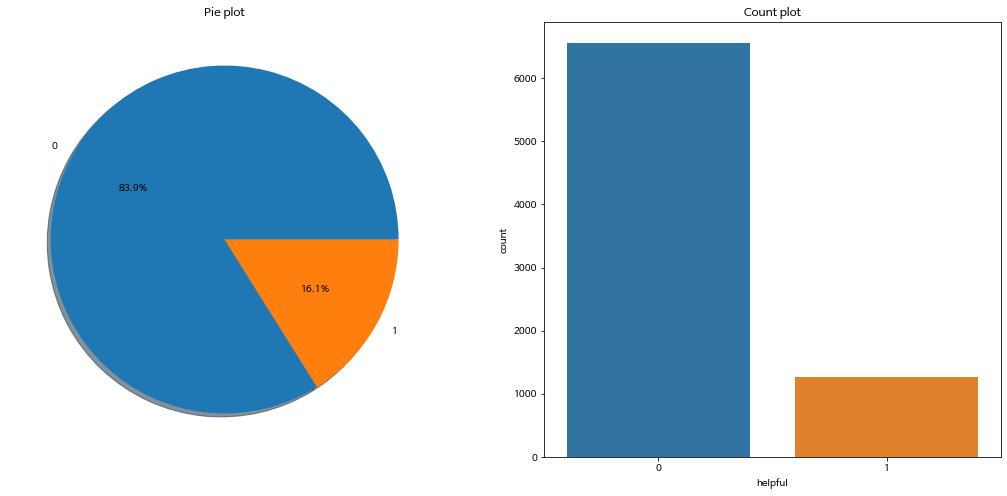

In [120]:
# Grade로 얼마나 있는지 비율 확인

f, ax = plt.subplots(1, 2, figsize=(18, 8))

df['helpful'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot')
ax[0].set_ylabel('')
sns.countplot('helpful', data=df, ax=ax[1])
ax[1].set_title('Count plot')
plt.show();

In [177]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1298
           1       0.76      0.48      0.59       267

    accuracy                           0.89      1565
   macro avg       0.83      0.72      0.76      1565
weighted avg       0.88      0.89      0.87      1565



# 실제 데이터 적용

In [180]:
print('1. flavor : ', clf_cv_6.predict(a)),
print('1. flavor : ', clf_cv_6.predict_proba(a))

1. flavor :  [0]
1. flavor :  [[0.9548894 0.0451106]]


In [190]:
new_help=new[['store_name', 'date','review_check','helpful']]
new_help.head()

,store_name,date,review_check,helpful
0,맛보리생돼지김치두루치기,2021.09.13,맛있어요 3명 기준 2인분 계란말이 추천,0
1,맛보리생돼지김치두루치기,2021.09.13,계란말이 추천합니다,0
2,와인코르크 강남점,2022.04.23,이 와인 추천으로 먹었는데 정말 맛있었어요 웃음 여러 가지 안주 먹었는데 치즈플레이...,1
3,맛보리생돼지김치두루치기,2022.08.26,맛있어요,0
4,맛보리생돼지김치두루치기,2022.08.22,맛있습니다,0


In [227]:
result = pd.DataFrame(columns=['result'])
for i in range(len(x_cv_dn_len_6)):
  a=np.array([x_cv_dn_len_6[i].tolist()])
  b=clf_cv_6.predict(a).tolist()
  result = result.append({'result' : b[0] }, ignore_index = True)
result

,result
0,0
1,0
2,1
3,0
4,0
...,...
153,0
154,1
155,0
156,0


In [243]:
result2 = pd.DataFrame(columns=['proba'])
for i in range(len(x_cv_dn_len_6)):
  a=np.array([x_cv_dn_len_6[i].tolist()])
  b=clf_cv_6.predict_proba(a).tolist()
  result2 = result2.append({'proba' : b[0] }, ignore_index = True)
result2

,proba
0,"[0.9548894013603083, 0.04511059863969169]"
1,"[0.9875172477900396, 0.012482752209960403]"
2,"[6.93303978914761e-05, 0.9999306696021085]"
3,"[0.9651238729419294, 0.034876127058070666]"
4,"[0.9651238729419294, 0.034876127058070666]"
...,...
153,"[0.8415267259437946, 0.15847327405620543]"
154,"[0.07686250520249405, 0.923137494797506]"
155,"[0.9538641206188714, 0.046135879381128585]"
156,"[0.9759838014281261, 0.024016198571873915]"


In [244]:
all = pd.concat([new_help,result],axis=1, join='inner')   #열방향(axis=1), 교집합(inner)
final=pd.concat([all,result2],axis=1, join='inner')
final

,store_name,date,review_check,helpful,result,proba
0,맛보리생돼지김치두루치기,2021.09.13,맛있어요 3명 기준 2인분 계란말이 추천,0,0,"[0.9548894013603083, 0.04511059863969169]"
1,맛보리생돼지김치두루치기,2021.09.13,계란말이 추천합니다,0,0,"[0.9875172477900396, 0.012482752209960403]"
2,와인코르크 강남점,2022.04.23,이 와인 추천으로 먹었는데 정말 맛있었어요 웃음 여러 가지 안주 먹었는데 치즈플레이...,1,1,"[6.93303978914761e-05, 0.9999306696021085]"
3,맛보리생돼지김치두루치기,2022.08.26,맛있어요,0,0,"[0.9651238729419294, 0.034876127058070666]"
4,맛보리생돼지김치두루치기,2022.08.22,맛있습니다,0,0,"[0.9651238729419294, 0.034876127058070666]"
...,...,...,...,...,...,...
153,와인코르크 강남점,2020.08.14,가격도 저렴하고 좋아요 웃음 재방문 의사 있습니다,0,0,"[0.8415267259437946, 0.15847327405620543]"
154,와인코르크 강남점,2020.07.29,강남역 분위기도 좋고 저렴한 와인 맛집 와인 종류도 많고 원하는 와인 골라서 가져다...,1,1,"[0.07686250520249405, 0.923137494797506]"
155,와인코르크 강남점,2020.05.04,샹그리아 맛집 웃음,0,0,"[0.9538641206188714, 0.046135879381128585]"
156,와인코르크 강남점,2020.05.01,강남에서 제일 좋은 와인 집,0,0,"[0.9759838014281261, 0.024016198571873915]"


In [250]:
final.tail(15)

,store_name,date,review_check,helpful,result,proba
143,와인코르크 강남점,2021.03.12,솔직히 왜 별점이 높은지 모르겠음 샹그리아도 다른데보다 양과 맛양에 비해 가격이 높...,1,0,"[0.5582672907549633, 0.44173270924503666]"
144,와인코르크 강남점,2021.03.03,굿,0,0,"[0.9852858614110556, 0.014714138588944412]"
145,와인코르크 강남점,2020.12.19,언제나 좋아요 4번째 방문이에요,0,0,"[0.963505961298203, 0.036494038701797016]"
146,와인코르크 강남점,2020.11.17,넓직한 내부에 와인을 골라서 마실 수 있단 게 너무 좋았습니다 가격대도 다양해서 선...,1,0,"[0.9138010473728951, 0.08619895262710488]"
147,와인코르크 강남점,2020.11.14,가성비 좋은 와인집에요,1,0,"[0.9395363700780536, 0.060463629921946434]"
148,와인코르크 강남점,2020.11.03,분위기 좋은 곳이에요 많이 시끄럽지 않아서 좋았어요 오늘의 와인도 맛있었습니다,1,1,"[0.4807821794859657, 0.5192178205140343]"
149,와인코르크 강남점,2020.10.24,좋아하는 곳 포인트 소멸이 빨리되는 게 아쉽다,1,0,"[0.9700330933946226, 0.029966906605377402]"
150,와인코르크 강남점,2020.10.05,분위기 굿,0,0,"[0.9274190033238585, 0.07258099667614147]"
151,와인코르크 강남점,2020.09.21,굿,0,0,"[0.9852858614110556, 0.014714138588944412]"
152,와인코르크 강남점,2020.08.23,친절해요,0,0,"[0.9315581698587309, 0.06844183014126916]"


In [263]:
print('전체:', len(final)),
print('맞음:', len(final[final['helpful']==final['result']])),
print('틀림:', len(final[final['helpful']!=final['result']]))
print('확률(%):',len(final[final['helpful']==final['result']])/len(final)*100)

전체: 158
맞음: 135
틀림: 23
확률(%): 85.44303797468355
